In [2]:
import os
import pandas as pd
from kaggle import KaggleApi
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

script_folder = os.path.dirname(os.path.abspath("__file__"))
destination_path = os.path.join(script_folder, "data")
dataset_name = 'amitanshjoshi/spotify-1million-tracks'
features = ['popularity', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_mins']
target = 'popularity'
HP_TUNING_FLAG = False

api = KaggleApi()
api.authenticate()

# Downloading the dataset
api.dataset_download_files(dataset_name, path=destination_path, unzip=True)

In [3]:
from enum import Enum

class Models(Enum):
    GRADIENT_BOOSTING = 'Gradient Boosting',
    GAUSSIAN_NB = 'Gaussian Naive Bayes',
    #MLP_REGRESSOR = 'MLP Regressor',
    LOG_REGRESSION = 'Logistic Regression',
    MLP_CLASSIFIER = 'MLP Classifier',
    KNN = 'KNN',
    RANDOM_FOREST = 'Random Forest',
    DECISION_TREE = 'Decision Tree',

In [4]:
def _get_model(mdl_type):
    if mdl_type == Models.GRADIENT_BOOSTING:
        return GradientBoostingClassifier(n_estimators=50,
                                              learning_rate=0.09,
                                              max_depth=5,
                                              verbose=True)
    elif mdl_type == Models.GAUSSIAN_NB:
        return GaussianNB()
    #elif mdl_type == Models.MLP_REGRESSOR:
        # return MLPRegressor(random_state=1,
        #                         max_iter=500,
        #                         verbose=True)
    elif mdl_type == Models.MLP_CLASSIFIER:
        return MLPClassifier(solver='adam',
                                 alpha=1e-5,
                                 hidden_layer_sizes=(5, 2),
                                 random_state=1,
                                 max_iter=1000,
                                 verbose=True)
    elif mdl_type == Models.KNN:
        return KNeighborsClassifier(n_neighbors=5)
    elif mdl_type == Models.RANDOM_FOREST:
        return RandomForestClassifier(n_estimators = 100)
    elif mdl_type == Models.DECISION_TREE:
        return DecisionTreeClassifier(random_state=42, max_depth=2)
    elif mdl_type == Models.LOG_REGRESSION:
        return linear_model.LogisticRegression(solver = 'lbfgs', max_iter = 1000)
    else:
        raise NotImplementedError


In [5]:
data_path = os.path.join(os.getcwd(), "data", "spotify_data.csv")
data = pd.read_csv(data_path)

In [6]:
data.head()
data.dtypes

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [7]:
data.describe()

,Unnamed: 0,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06
mean,6.590613e+05,1.838312e+01,2.011955e+03,5.374382e-01,6.396699e-01,5.287778e+00,-8.981353e+00,6.346533e-01,9.281477e-02,3.215370e-01,2.523489e-01,2.230189e-01,4.555636e-01,1.213771e+02,2.495618e+05,3.885879e+00
std,4.285492e+05,1.588554e+01,6.803901e+00,1.844780e-01,2.705009e-01,3.555197e+00,5.682215e+00,4.815275e-01,1.268409e-01,3.549872e-01,3.650731e-01,2.010707e-01,2.685190e-01,2.977975e+01,1.494262e+05,4.676967e-01
min,0.000000e+00,0.000000e+00,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-5.810000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.073000e+03,0.000000e+00
25%,2.899408e+05,5.000000e+00,2.006000e+03,4.130000e-01,4.540000e-01,2.000000e+00,-1.082900e+01,0.000000e+00,3.710000e-02,6.400000e-03,1.050000e-06,9.790000e-02,2.260000e-01,9.879700e+01,1.810910e+05,4.000000e+00
50%,5.798815e+05,1.500000e+01,2.012000e+03,5.500000e-01,6.940000e-01,5.000000e+00,-7.450000e+00,1.000000e+00,5.070000e-02,1.470000e-01,1.760000e-03,1.340000e-01,4.380000e-01,1.219310e+02,2.257440e+05,4.000000e+00
75%,1.031689e+06,2.900000e+01,2.018000e+03,6.770000e-01,8.730000e-01,8.000000e+00,-5.276000e+00,1.000000e+00,8.900000e-02,6.400000e-01,6.140000e-01,2.920000e-01,6.740000e-01,1.399030e+02,2.869135e+05,4.000000e+00
max,1.473395e+06,1.000000e+02,2.023000e+03,9.930000e-01,1.000000e+00,1.100000e+01,6.172000e+00,1.000000e+00,9.710000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.499930e+02,6.000495e+06,5.000000e+00


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>],
       [<Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'duration_ms'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

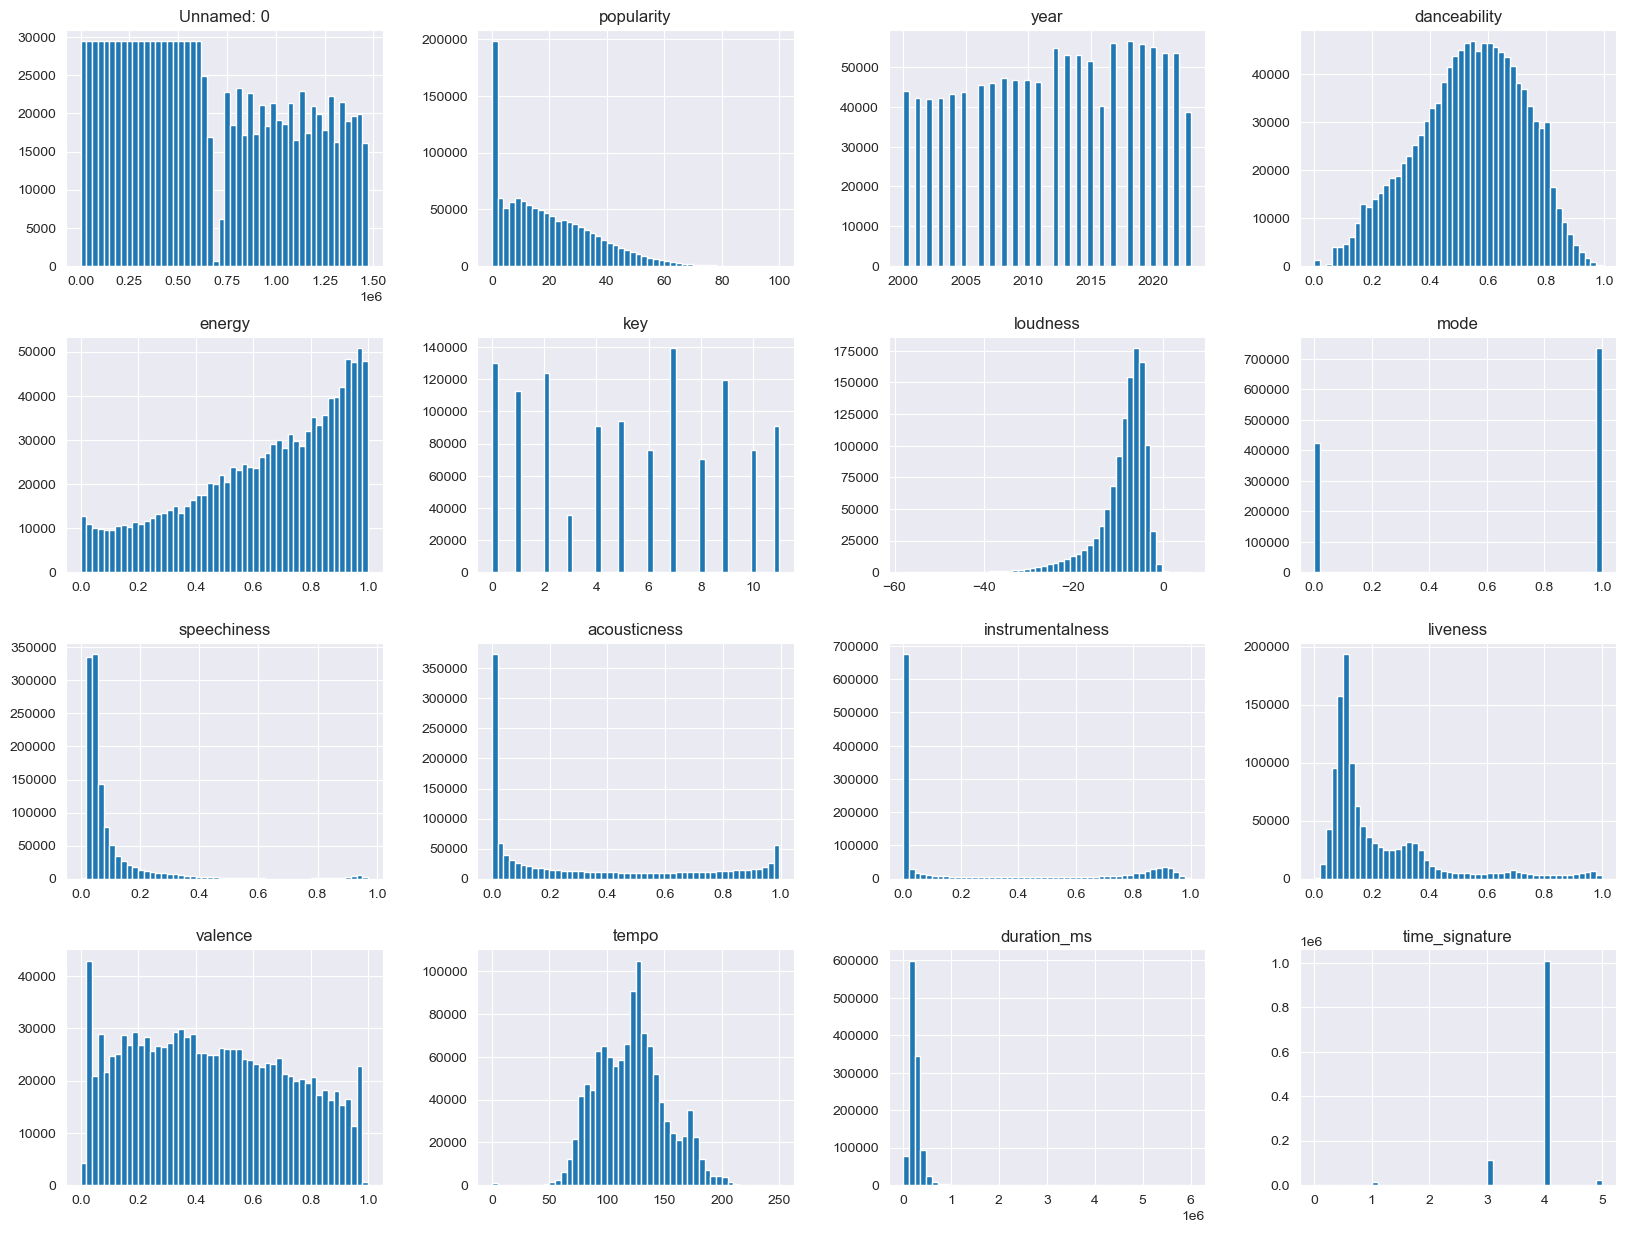

In [9]:
#plotting histogram for all the columns/features of data
data.hist(bins=50, figsize=(20, 15))

In [10]:
data['duration_mins'] = data['duration_ms'] / 60000
data['duration_mins']

0          4.002767
1          3.606450
2          2.649333
3          5.071550
4          4.072000
             ...   
1159759    5.733550
1159760    4.751117
1159761    3.570883
1159762    3.985550
1159763    3.537117
Name: duration_mins, Length: 1159764, dtype: float64

In [11]:
data = data.drop(['track_id', 'duration_ms'], axis=1)
data.head()

,Unnamed: 0,artist_name,track_name,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_mins
0,0,Jason Mraz,I Won't Give Up,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,3,4.002767
1,1,Jason Mraz,93 Million Miles,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,4,3.606450
2,2,Joshua Hyslop,Do Not Let Me Go,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,4,2.649333
3,3,Boyce Avenue,Fast Car,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,4,5.071550
4,4,Andrew Belle,Sky's Still Blue,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,4,4.072000


In [12]:
attributes = data[features]
corr_matrix = attributes.corr()
corr_matrix['popularity'].sort_values(ascending=False)

popularity          1.000000
year                0.345821
loudness            0.104097
danceability        0.098533
time_signature      0.030830
energy              0.009401
tempo               0.002566
key                 0.000390
valence            -0.018070
mode               -0.023837
speechiness        -0.024700
liveness           -0.056968
acousticness       -0.059181
duration_mins      -0.118484
instrumentalness   -0.152893
Name: popularity, dtype: float64

Text(0.5, 1.0, 'Correlation Matrix')

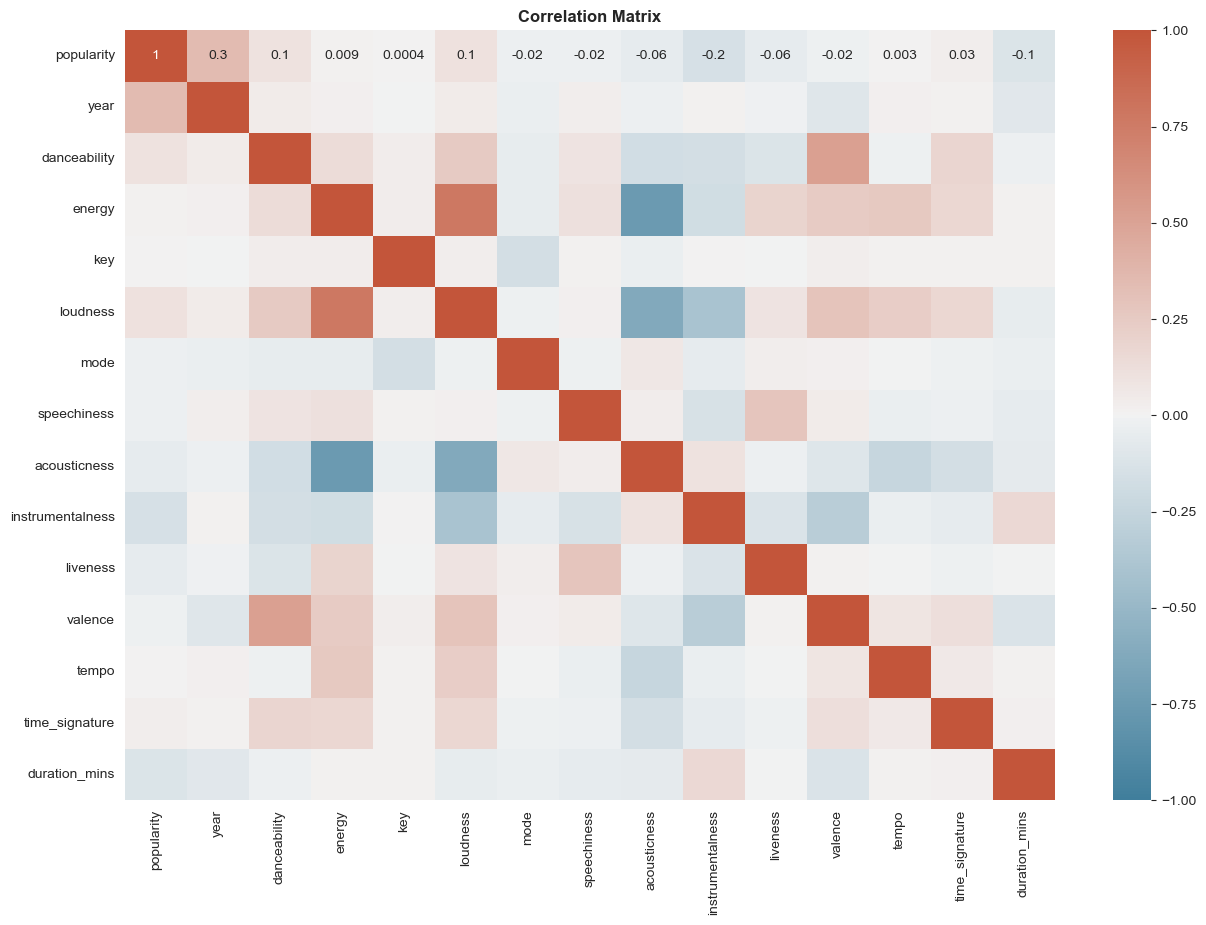

In [13]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(15, 10))
sns.heatmap(attributes.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap=cmap)
plt.title("Correlation Matrix", fontweight='bold', fontsize='large')

In [14]:
corr_matrix = attributes.corr()
corr_pairs = corr_matrix.unstack()
positive_corr = corr_pairs[(corr_pairs >= 0.5) & (corr_pairs < 1)]
print("Highly Correlated Pairs: \n", positive_corr)


negative_corr = corr_pairs[(corr_pairs <= -0.5) & (corr_pairs > -1)]
print("\nLess Correlated Pairs: \n", negative_corr)

KeyboardInterrupt: 

In [ ]:
popularity_verdict = data.copy()
popularity_verdict['verdict'] = ''

for i, row in popularity_verdict.iterrows():
    score = 'low'
    if row.popularity >= 50:
        score = 'popular'
    popularity_verdict.at[i, 'verdict'] = score


In [ ]:
popularity_verdict[['artist_name', 'track_name', 'popularity', 'verdict']].head()


In [ ]:
popularity_verdict[['artist_name', 'track_name', 'popularity', 'verdict']].head()


In [ ]:
popularity_verdict[['popularity']].value_counts()


In [ ]:
print('Number of songs with 0 as popularity value: ', len(popularity_verdict[popularity_verdict.popularity == 0]))


In [ ]:
popularity_verdict = popularity_verdict.sort_values('popularity', ascending=False).reset_index()

In [ ]:
popularity_verdict.tail()


In [ ]:
#as almost 15% of entries have 0 popularity score, we drop the records with 0 popularity score as this will help
#model in predicting better. 0 value records will not have significance in our analysis.
popularity_verdict = popularity_verdict[popularity_verdict.popularity > 0]

#last 5 records with popularity score = 1, hence records with popularity score = 0 are dropped
popularity_verdict.tail()

In [ ]:
#plotting histogram for popularity score distribution
popularity_verdict['popularity'].plot(kind='hist', bins=50)
plt.xlabel('Popularity Score')
plt.ylabel('Number of Songs')
plt.title('Popularity Score Distribution')


In [ ]:
#popularity vs loudness scatterplot
fig, ax = plt.subplots(figsize= (15, 10))
sns.scatterplot(data = popularity_verdict, x = 'popularity', y = 'loudness', hue = 'verdict', size = 'verdict', sizes = (20, 200), legend = 'full')

In [ ]:
#popularity vs danceability scatter plot
fig, ax = plt.subplots(figsize= (15, 10))
sns.scatterplot(data = popularity_verdict, x = 'popularity', y = 'danceability', hue = 'verdict', size = 'verdict', sizes = (20, 200), legend = 'full')

In [ ]:
pop_ver_att = popularity_verdict[['year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_mins']]

In [ ]:
X = pop_ver_att.select_dtypes(include='number')
y = popularity_verdict['verdict']

In [ ]:
scaler = StandardScaler()
model_X = scaler.fit(X)
X_scaled = model_X.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.3, shuffle=True)

In [ ]:
from sklearn import metrics, linear_model

model_results = {}
for mdl_typ in Models:
    print('Now training Model type', mdl_typ.value[0])
    metrics_dict = {}
    mdl = _get_model(mdl_typ)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    metrics_dict['accuracy'] = metrics.accuracy_score(y_test, y_pred) * 100
    metrics_dict['confusion matrix'] = confusion_matrix(y_test, y_pred)
    metrics_dict['classification report'] = classification_report(y_test, y_pred)
    model_results[mdl_typ.value[0]] = metrics_dict


In [ ]:
for k, v in model_results.items():
   print('#' * 60)
   print('\t\t\t\t\t {} Results'.format( k))
   print('#' * 60)
   print(v['confusion matrix'])
   print('-' * 30)
   print(v['classification report'])
   print('-' * 30)
   print('The {} Model had an accuracy of {}'.format(k, v['accuracy']))

